# TIME SERIES ECONOMETRICS

* * *

Economic time series (series of data points indexed in time order) are considered to be realizations of stochastic processes.
That is, each point of an economic time series is considered to be an observation of a random variable.

We can look at a stochastic process as a sequence of variables characterized by joint probability distributions for every finite set of different time points. In particular, we can consider the distribution $f(x_t)$ of each variable $X_t$ at each moment. 

In [47]:
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from numpy.random import multivariate_normal
import yfinance as yf

import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import math

import random
random.seed(1000)

## Integration, Cointegration, and Stationarity
- - -

### Stationarity

The foundation of time series analysis is stationarity. 

A time seties ${r_t}$ is said to be *strictly stationaty* if the joint distribution of $(R_{t_1}, \dots , R_{t_k})$ is identical to that of $(R_{t_{1+j}}, \dots , R_{t_{k+j}})$. In other words, strict stationarity requieres that the joint distribution $(R_{t_1}, \dots , R_{t_k})$ is invariant under time shift. Since this is a very strong condition and hardly verified, a weaker version is often assumed. 

A time series ${r_t}$ is *weakly invariant* if both the mean of $r_t$ and the covariance between $r_t$ and $r_{t-j}$ are time invariant, where j is an arbitrary integer. That is:
- $E(r_t) =\mu$, which is a constant
- $Cov(r_t, r_{t-j}) = \sigma_j$, which only depends on j.

Stationarity is so important because it enables one to make inference concerning futures observations.

To observe how stationary series behave, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [48]:
def generate_series(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

''

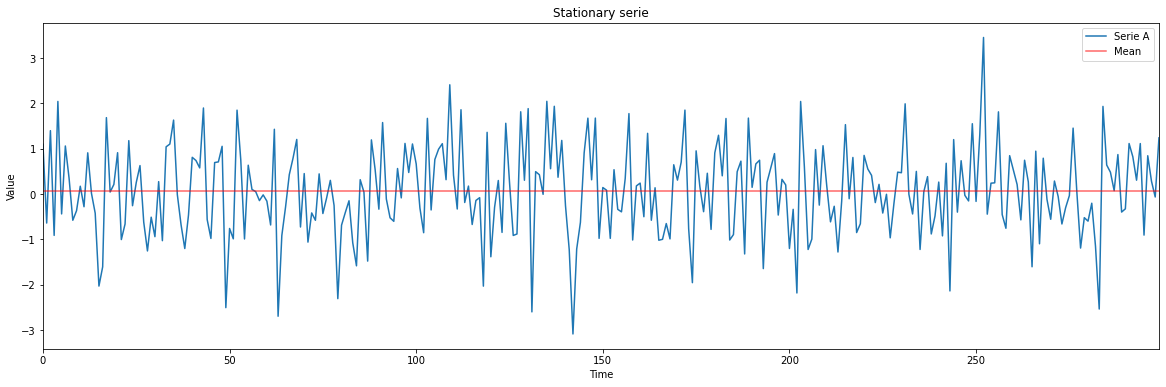

In [49]:
#SERIE A

params = (0, 1)
T = 300

A = np.zeros(T)
A = pd.Series(A, name ='A')
for t in range(T):
     A[t] = generate_series(params)


fig = plt.figure(figsize=(20,6))        
plt.plot(A, label = 'Serie A')
plt.axhline(A.mean(), color='red', alpha = 0.6, label = 'Mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Stationary serie')
plt.autoscale(tight=True, axis='x')
;

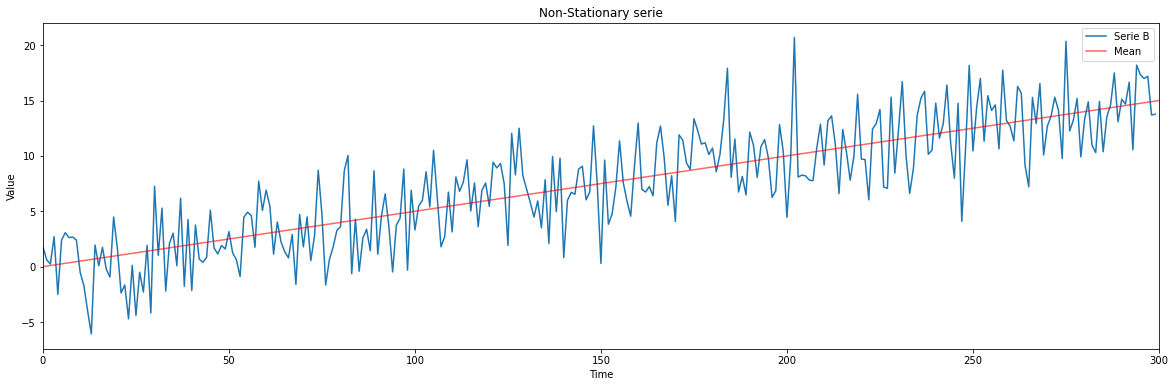

In [50]:
#SERIE B

T = 300
B = np.zeros(T)
B = pd.Series(B, name ='B')

for t in range(T):
    params = (t*0.05, 3)
    B[t] = generate_series(params)


fig = plt.figure(figsize=(20,6))        
plt.plot(B, label='Serie B')
plt.plot(np.linspace(0,T), np.linspace(0,T)*0.05, color='red', alpha = 0.6, label='Mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Non-Stationary serie')
plt.autoscale(tight=True, axis='x');

**Why Non-Stationarity is dangerous?**  Many statistical tests require that the data being tested are stationary. Since most of them are based on the mean of the sample, it the serie is not stationary it won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. 

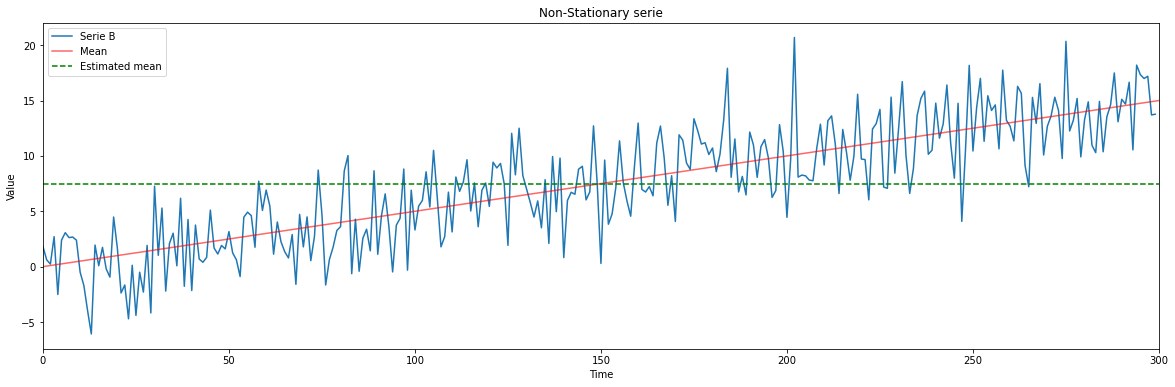

In [51]:
fig = plt.figure(figsize=(20,6))        
plt.plot(B, label='Serie B')
plt.plot(np.linspace(0,T), np.linspace(0,T)*0.05, color='red', alpha = 0.6, label='Mean')
plt.axhline(B.mean(), color = 'green', linestyle = 'dashed', label = 'Estimated mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Non-Stationary serie')
plt.autoscale(tight=True, axis='x')

### Testing for Stationarity

The Augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample, which means that the serie is nonstationary.

In [52]:
def check_for_stationarity(X, cutoff=0.01):
    
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(round(pvalue,4)) + ' The series ' + X.name +' is likely stationary.' )

    else:
        print ('p-value = ' + str(round(pvalue,4)) + ' The series ' + X.name +' is likely non-stationary.')
    
    return 

In [53]:
check_for_stationarity(A)
check_for_stationarity(B)

p-value = 0.0 The series A is likely stationary.
p-value = 0.8967 The series B is likely non-stationary.


A non-stationary serie is said to have a **unit root** or to be **integrated**. We will denote integration order-i as $I(i)$.

If a serie is $I(d)$ it has $d$ unit roots and yields a stationary process by taking repeated differences $d$ times. Similarly, to get a $I(d)$ serie, we can take an $I(0)$ series and iteratively take the cumulative sum $d$ times (which is the discrete way of integration).


### Spurious regresion

One of the problems that I(1) series is that they may lead to the so-called **spourious regression** phenomenon. 

Suppose that two $I(1)$ processes, $y_t$ and $x_t$, are independently distributed. Consider the following simple regression:
$$ y_t = \beta x_t + \mu_t$$

Since $y_t$ and $x_t$ are independent, there should be no systematic relationship between them, and therefore, we should expect that an OLS estimate of $\beta$ should be close to zero. Nevertheless, in the case of spurious regression, $\hat{\beta}$ does not converge to its true value of zero, and its t-statistic always indicates significance of the estimate. 

### Real data

In [54]:
apple = yf.download('AAPL', period='5y')['Adj Close']
apple.name = 'AAPL'

[*********************100%***********************]  1 of 1 completed


In [55]:
check_for_stationarity(apple)

p-value = 0.9959 The series AAPL is likely non-stationary.


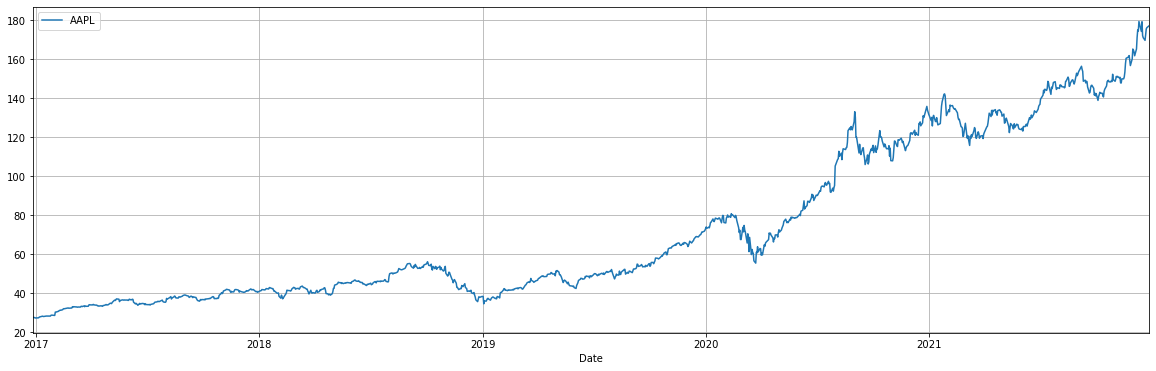

In [56]:
fig = plt.figure(figsize = (20,6))
plt.plot(apple, label = 'AAPL')
plt.xlabel('Date')
plt.legend(loc ='best')
plt.grid(True)
plt.autoscale(axis = 'x', tight =True)

Now let's take calculate first differences of the serie and returns and check stationary again.

In [57]:
d_apple = apple.diff()[1:]
d_apple.name = 'AAPL first differences'
check_for_stationarity(d_apple)

p-value = 0.0 The series AAPL first differences is likely stationary.


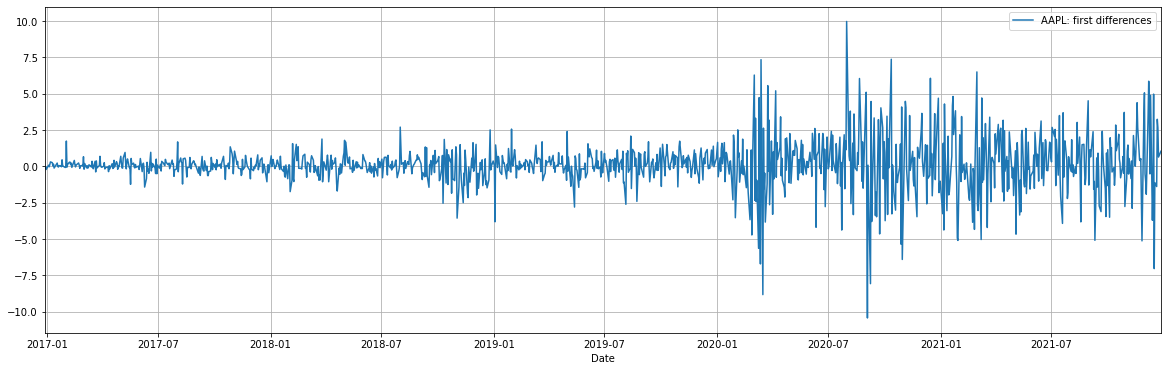

In [58]:
fig = plt.figure(figsize = (20,6))
plt.plot(d_apple, label = 'AAPL: first differences')
plt.xlabel('Date')
plt.legend(loc ='best')
plt.grid(True)
plt.autoscale(axis = 'x', tight =True)

In [59]:
rets_apple = apple.pct_change()[1:]
rets_apple.name = 'AAPL returns'
check_for_stationarity(rets_apple)

p-value = 0.0 The series AAPL returns is likely stationary.


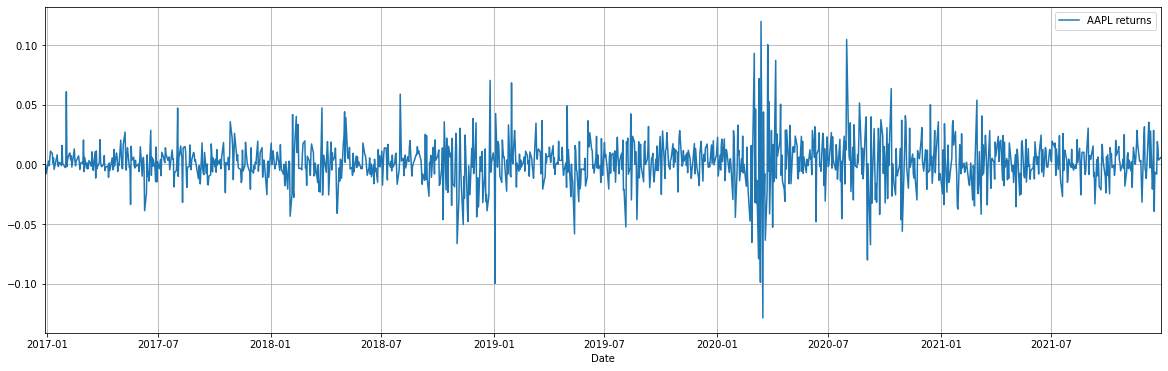

In [60]:
fig = plt.figure(figsize = (20,6))
plt.plot(rets_apple, label = 'AAPL returns')
plt.xlabel('Date')
plt.legend(loc ='best')
plt.grid(True)
plt.autoscale(axis = 'x', tight =True)

***Note:*** The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible.

## Cointegration

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.


**Linear combination:** A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y=b_1X_1+b_2X_2+⋯+b_kX_k$$


**Cointegration:** For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

Cointegration is a more subtle relationship than correlation. If two time series are cointegrated, there is some linear combination between them that will vary around a mean. At all points in time, the combination between them is related to the same probability distribution.

If we find two cointegreted assets, $A_1, A_2$, this mean that the linear combination of their prices $B = b_1A_1 + b_2A_2$ is mean reverting and we can bet on $B$ and place trades accordingly.


### Simulated data example


In [61]:
N = 200

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)

# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1, name = 'X1')

# Define X2 that is a constant + X1 + some noise
noise = np.random.normal(0, 1, N)
const = 3
X2 = const + X1 + noise
X2.name ='X2'

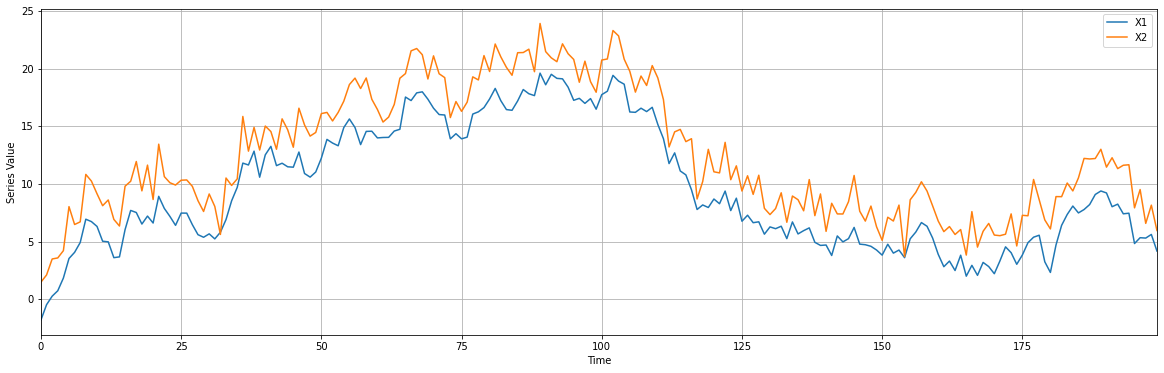

In [62]:
fig = plt.figure(figsize = (20,6))
plt.plot(X1, label = 'X1')
plt.plot(X2, label = 'X2')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True);

In [63]:
check_for_stationarity(X1)
check_for_stationarity(X2)

p-value = 0.4234 The series X1 is likely non-stationary.
p-value = 0.2756 The series X2 is likely non-stationary.


Now to show cointegration we'll need to find some linear combination of $X_1$ and $X_2$ that is stationary. We can take $X_2-X_1$. All that's left over should be stationary noise by design. Let's check this.

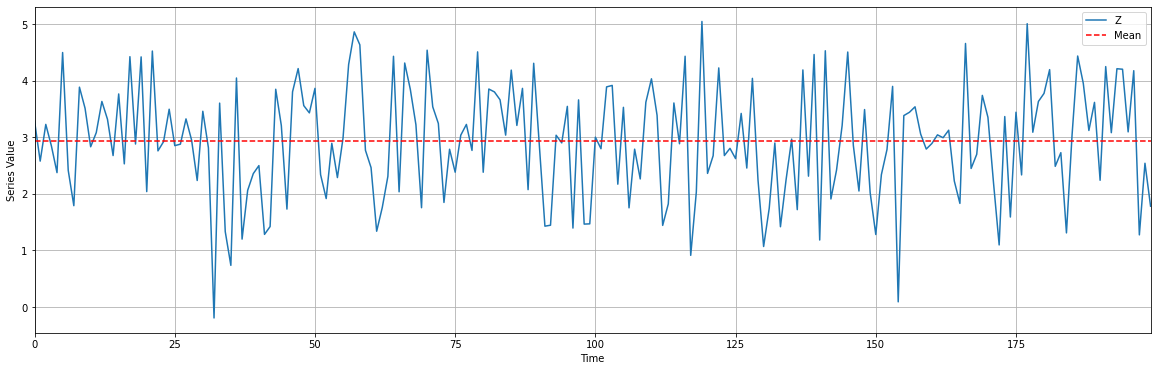

In [64]:
Z = X2 - X1
Z.name = 'Z'


fig = plt.figure(figsize = (20,6))
plt.plot(Z, label = 'Z')
plt.axhline(Z.mean(), color='red', linestyle='--', label = 'Mean')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True);

In [65]:
check_for_stationarity(Z)

p-value = 0.0 The series Z is likely stationary.


### Testing for Cointegration

There are a bunch of ways to test for cointegration. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. 

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.
$$X_2=\alpha+\beta X_1+\mu$$

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \mu$ should be stationary.

Notice that for $X_1$ and $X_2$ to be cointegrated, $\mu$ should be $I(0)$. Otherwise, the relationship could be spurious.

There is a convenient cointegration test that lives in **statsmodels.tsa.stattools**. Let's say that our confidence level is 0.05. We should see a p-value below our cutoff, as we've artifically created two series that are the textbook definition of cointegration.

In [66]:
score, pvalue, _ = coint(X1,X2)
print(pvalue)

3.261321050134743e-13


### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similar, are not the same. To demonstrate this, we'll show examples of series that are correlated, but not cointegrated, and vice versa. To start let's check the correlation of the series we just generated.

In [67]:
X1.corr(X2)

0.9829434942499113

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look?

### Correlation without cointegration

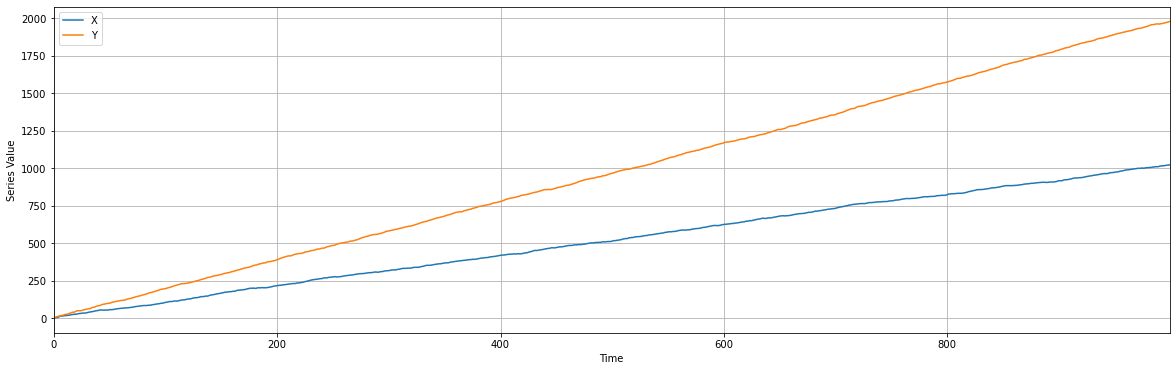

In [68]:
X_returns = np.random.normal(1, 1, 1000)
Y_returns = np.random.normal(2, 1, 1000)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

fig = plt.figure(figsize = (20,6))
plt.plot(X_diverging, label = 'X')
plt.plot(Y_diverging, label = 'Y')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)

In [69]:
print ('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print ('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.999380240782604
Cointegration test p-value: 0.5687276650595733


### Cointegration without correlation

A simple example of this case is a normally distributed series and a square wave.

In [70]:
N = 1000
Y1 = pd.Series(np.random.normal(0, 1, N), name='Y1') + 20
Y2 = Y1.copy()

Y2[0:100] = 30
Y2[100:200] = 10
Y2[200:300] = 30
Y2[300:400] = 10
Y2[400:500] = 30
Y2[500:600] = 10
Y2[600:700] = 30
Y2[700:800] = 10
Y2[800:900] = 30
Y2[900:1000] = 10

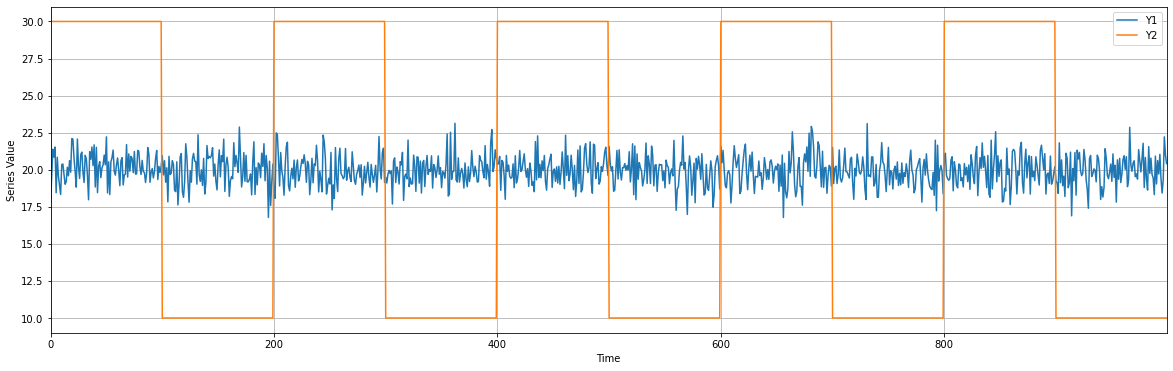

In [71]:
fig = plt.figure(figsize = (20,6))
plt.plot(Y1, label = 'Y1')
plt.plot(Y2, label = 'Y2')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)

In [72]:
print('Correlation: ' + str(Y1.corr(Y2)))
score, pvalue, _ = coint(Y1,Y2)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.04576487231186779
Cointegration test p-value: 0.0


## Autocorrelation and AR Models

- - -

Autocorrelation is one of the most common effects in financial time series. It describes the phenomena of future values being dependent on current and past values as well as new information. Autocorrelation also leads to fat tails and tail risk, which can sink your algorithm if you assume underlying distributions are not autoregressive. Because there is so much autocorrelation in finance we should understand how to effectively model it.
 
### AR Models
An autoregressive, or $AR(p)$, model is created by regressing a time series on its past values, its lags. The simplest form of an autoregressive model is an $AR(1)$ model, signifying using only one lag term. A first order autocorrelation model like this for a time series $y_t$ is:

$$
y_t = b_0 + b_1 y_{t - 1} + \epsilon_t
$$

Where $y_{t - 1}$ represents the value of the time series at time $(t - 1)$ and $\epsilon_t$ is the error term. We can extend this to an $AR(p)$ model, denoted:

$$
y_t = b_0 + b_1 y_{t-1} + b_2 y_{t - 2} \ldots + b_p y_{t - p} + \epsilon_t
$$

For an $AR$ model to function properly, we must require that the time series is covariance stationary. This means that it follows three conditions:

1. The expected value of the time series is constant and finite at all times, i.e. $E(y_t) = \mu$ and $|\mu| < \infty$ for all values of $t$.
2. The variance of the time series is constant and finite for all time periods, i.e. $V(y_t) = \sigma^2$ and $\sigma^2  < \infty$ for all values of $t$.
3. The covariance of the time series with itself for a fixed number of periods in either the future or the past is constant and finite for all time periods, i.e

$$
COV(y_t, y_{t - s}) = \lambda, \  |\lambda| < \infty, \text{ $\lambda$ constant}, \  t = 1, 2, \ \ldots, T; \  s = 0, \pm 1, \pm 2, \ldots, \pm T
$$

Note that this mathematical representation includes condition 2.

If these conditions are not satisfied, our estimation results will not have real-world meaning. Our estimates for the parameters will be biased, making any tests that we try to form using the model invalid. Unfortunately, it can be a real pain to find a covariance-stationary time series in the wild in financial markets. 


### Simulating Data

Here we will draw data samples from a simulated $AR(3)$ process.

In [73]:
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05])
X = np.array([1])

mu = 0
sigma = 1

for i in range(1000):
    X = np.append(X, AR(b, X, mu, sigma))
    
X = pd.Series(X, name = 'X')

Text(0, 0.5, 'AR Series Value')

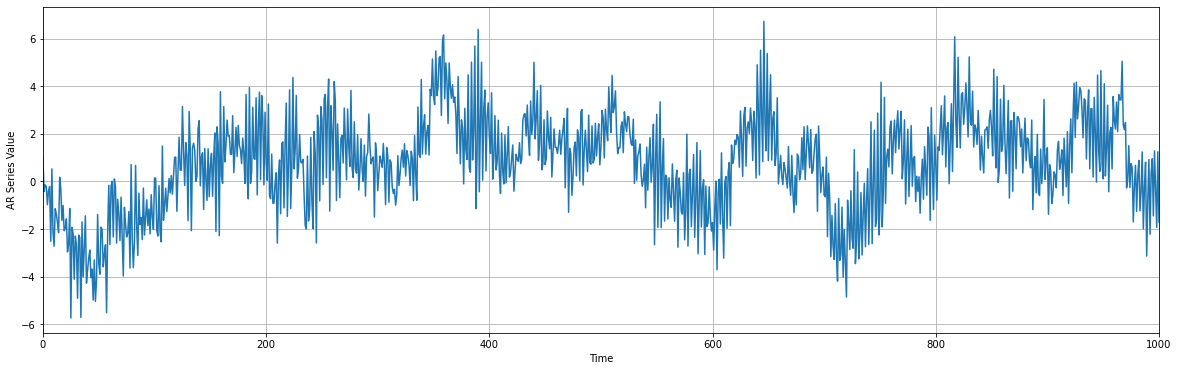

In [74]:
fig = plt.figure(figsize = (20,6))
plt.plot(X)
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.xlabel('Time')
plt.ylabel('AR Series Value')

Note how this process fluctuates around some central value. This value is the mean of our time series.

In [75]:
check_for_stationarity(X)

p-value = 0.008 The series X is likely stationary.


### Tail Risk

Autoregressive processes will tend to have more extreme values than data drawn from, for example, a normal distribution. This is because the value at each time point is influenced by recent values. If the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as 'fat-tailledness' (fat-tailed distribution) because the extremes on the pdf will be fatter than in a normal distribution.

Much talk of tail risk in finance comes from the fact that tail events do occur and are hard to model due to their infrequent occurrence. If we have reason to suspect that a process is autoregressive, we should expect risk from extreme tail events and adjust accordingly.

AR models are just one of the sources of tail risk, so don't assume that because a series is non-AR it does not have tail risk.

Let's now check for that behavior.

In [76]:
Y = np.random.normal(0,1, 1000)

Text(0.5, 0, 'Value')

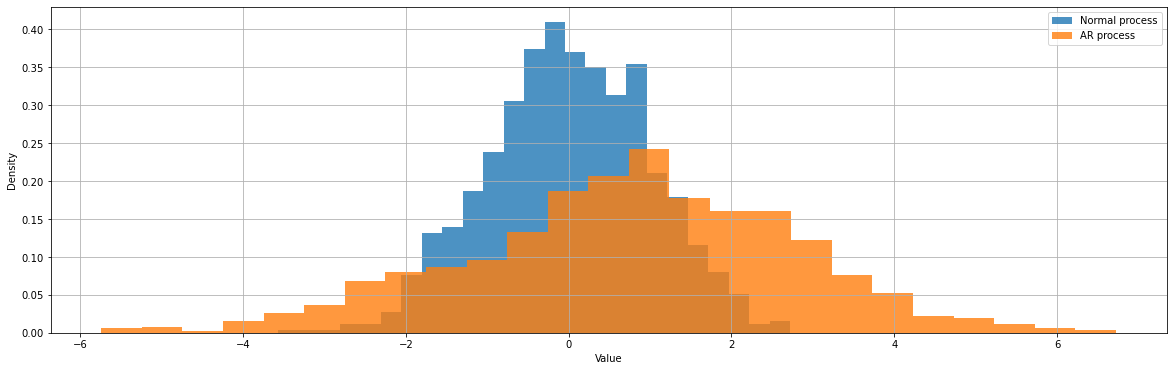

In [77]:
fig = plt.figure(figsize = (20,6))
plt.hist(Y, bins= 25, alpha = 0.8, density = True, label = 'Normal process')
plt.hist(X, bins = 25, alpha=0.8, density = True, label = 'AR process')
plt.grid(True)
plt.legend(loc = 'best')
plt.ylabel('Density')
plt.xlabel('Value')

**Estimations of variance will be wrong**: Because an AR process has a tail heavy and non-normal distribution of outcomes, estimates of variance on AR processes will be wrong. This is dangerous because variance is used to calculate many quantities in staistics, most importantly confidence intervals and p-values. Because the width of the confidence interval is often based on a variance estimate, we can no longer trust p-values that come from AR processes.



### Testing for AR Behavior

In order to determine the order, $p$, of an $AR(p)$ model, we look at the autocorrelations of the time series. These are the correlations of the series with its past values. The $k$-th order autocorrelation is

$$
\rho_k = \frac{COV(y_t, y_{t - k})}{\sigma_y^2} = \dfrac{E[(y_t - \mu)(y_{t - k} - \mu)]}{\sigma_y^2}
$$

Where $k$ represents the number of periods lagged. We cannot directly observe the autocorrelations so we estimate them as: 

$$
\hat{\rho}_k = \frac{\sum_{t = k + 1}^T[(y_t - \bar{y})(y_{t - k} - \bar{y})]}{\sum_{t = 1}^T (y_t - \bar{y})^2}
$$

For our purposes, we can use a pair of tools called the autocorrelation function (ACF) and the partial autocorrelation function (PACF) in order to determine the order of our model. 

**ACF** plot is a bar chart of coefficients of correlation between a time series and it lagged values. Simply stated: ACF explains how the present value of a given time series is correlated with the past ($t-1$, $t-2$, …, $t-n$) values. 

**PACF** is the partial autocorrelation function that explains the partial correlation between the series and lags of itself. In simple terms, PACF can be explained using a linear regression where we predict $y_t$ from $y_{t-1}$, $y_{t-2}$, and $y_{t-3}$. In PACF, we correlate the “parts” of $y_t$ and $y_{t-3}$ that are not predicted by $y_{t-1}$ and $y_{t-2}$.

The PACF controls for shorter lags, unlike the ACF. These functions are included with many statistical packages and compute the sample autocorrelations for us, allowing us to determine the appropriate value of $p$.

We will demonstrate these functions on our above example of a stationary series:

In [78]:
from statsmodels.tsa.stattools import acf, pacf

def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

In [79]:
nlags = 40

X_acf = acf(X, nlags=nlags, fft=False)
print('Autocorrelations:\n' + str(X_acf) + '\n')
X_pacf = pacf(X, nlags=nlags)
print('Partial Autocorrelations:\n' + str(X_pacf))

Autocorrelations:
[1.         0.46686708 0.4908378  0.8598377  0.44100595 0.48554238
 0.75013098 0.41978281 0.47448661 0.64752502 0.39776132 0.4608325
 0.55324319 0.37944072 0.43377485 0.47319633 0.35410002 0.38254757
 0.42024536 0.31863043 0.33712967 0.37680552 0.30675744 0.30498124
 0.33743904 0.2895572  0.27966882 0.29961073 0.26659535 0.2651057
 0.26192018 0.24269235 0.25033809 0.21690643 0.21881882 0.227906
 0.19917555 0.19552239 0.19954342 0.18033928 0.16755186]

Partial Autocorrelations:
[ 1.00000000e+00  4.67333950e-01  3.49820615e-01  8.01076260e-01
 -1.74946708e-02 -3.28644973e-02  2.45710628e-02  1.05391664e-02
  1.15321127e-02 -4.70600944e-02 -4.69933817e-03  3.24280850e-02
 -4.68617013e-02  7.90697336e-03 -1.18982775e-02 -2.11939627e-02
 -1.98540238e-02 -8.15526927e-02  5.83401994e-02 -2.94123469e-02
 -1.42439468e-02  2.44020259e-02  8.83042012e-02  2.71680146e-02
 -2.87192855e-02  7.64597503e-05  2.83130653e-02 -2.59147185e-02
 -2.12002462e-02  3.89397989e-02 -1.54793616e

Text(0.5, 1.0, 'ACF')

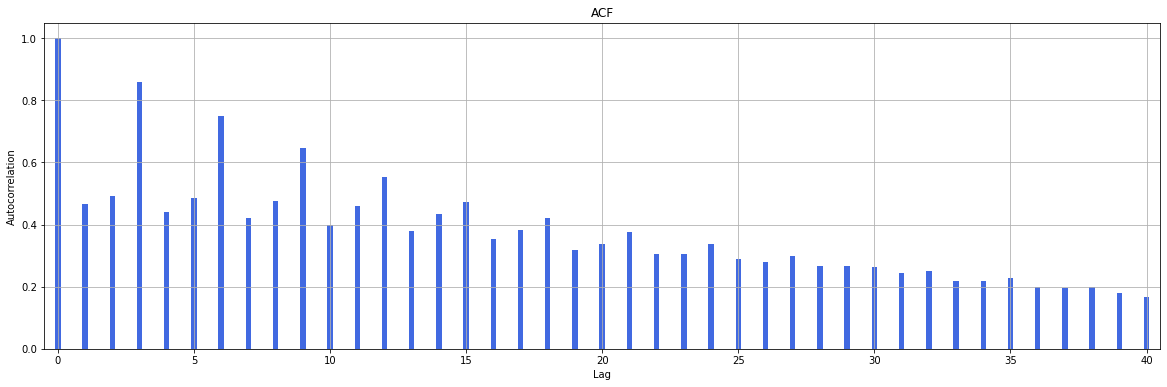

In [80]:
fig = plt.figure(figsize=(20,6))
for x,y in zip(range(nlags+1), X_acf):
    plt.bar(x, y, color = 'royalblue', width=0.2)
plt.grid(True)
plt.xlim(-0.5, 40.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("ACF")

Text(0.5, 1.0, 'PACF')

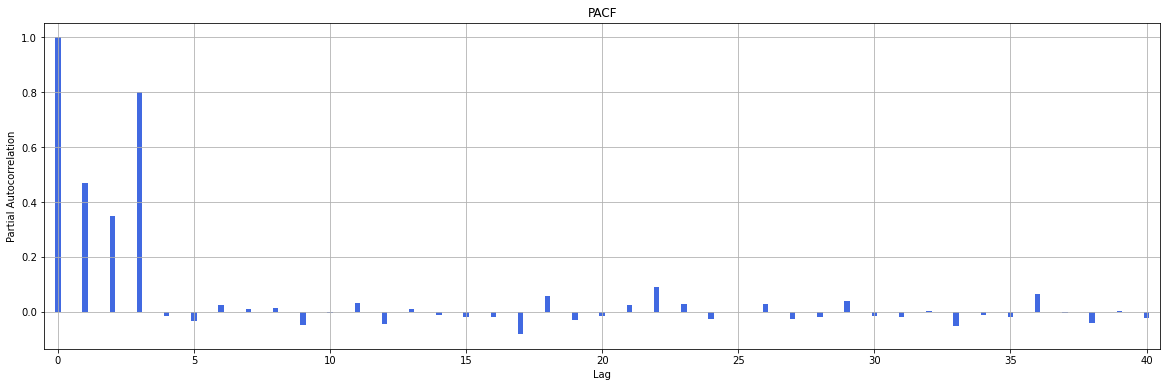

In [81]:
fig = plt.figure(figsize=(20,6))
for x,y in zip(range(nlags+1), X_pacf):
    plt.bar(x, y, color = 'royalblue', width=0.2)
plt.grid(True)
plt.xlim(-0.5, 40.5)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title("PACF")

Another way to plot ACF and PACF is using statsmodels.graphics.tsaplots, which aditionally shows confidence levels for the coefficients.

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

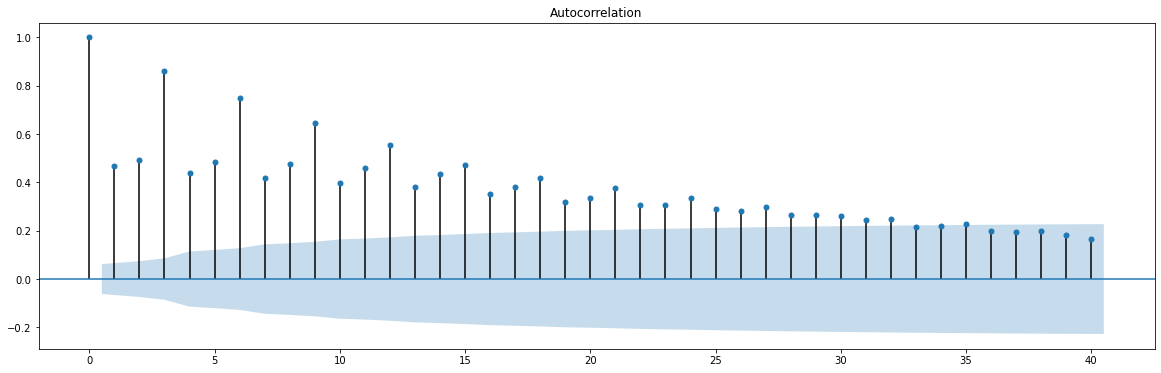

In [83]:
fig, ax= plt.subplots(figsize=(20, 6))
plot_acf(X, lags = 40, ax=ax)
plt.show()

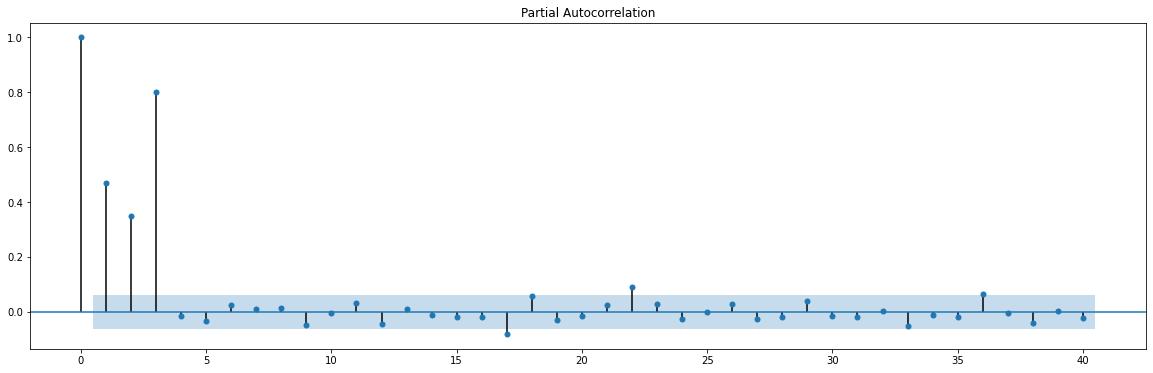

In [84]:
fig, ax= plt.subplots(figsize=(20, 6))
plot_pacf(X, lags = 40, ax=ax)
plt.show()

## Fitting an AR model

We'll use one of the functions already implemented in Python to fit an AR model. We'll try this on our simulated data first.

In [85]:
import statsmodels.tsa as tsa

In [86]:
model = tsa.api.AutoReg(X, 10).fit()

In [87]:
print("%13s %17s" % ('Parameters', 'Standard Error'))
print(33 * "-")
for pair in zip(model.params, model.bse):
    print("%11.2f %15.3f" % (pair[0], pair[1]))

   Parameters    Standard Error
---------------------------------
       0.06           0.035
       0.05           0.032
       0.13           0.032
       0.79           0.032
      -0.04           0.041
      -0.04           0.041
       0.06           0.041
       0.02           0.041
       0.02           0.032
      -0.04           0.032
      -0.00           0.032


### Choosing the number of lags

#### Estimations yield too many lags

We can see our model estimated quite a few parameters. In this case we know there are too many because we simulated the data as an AR(3) process. The reason that AR models will estimate many more lags than is actually the case is due to indirect dependency. If  $X_t$  depends on  $X_{t−1}$ , then indirectly and to a lesser extent it will depend on  $X_{t−2}$ . In the presence of more than one lag in the data generating process, we will get potentially complex harmonic structures in the lags. These indirect dependencies will be picked up by a simple estimation.

In general it's rarely the case that you can get anything useful out of a model with many parameters. In this case we want to select a number of lags that we believe explains what is happening, but without overfitting and choosing a model with way too many lags.

Observing the ACF and PACF indicates that only the first 3 lags may be useful. However, we will expand the number of lags to 10 to double-check our initial data. We will use information criterion, specifically **Akaike Information Criterion (AIC)** and **Bayes Information Criterion (BIC)** to decide the correct number of parameters.

Interpreting the AIC and BIC is done as follows. Compute the AIC and BIC for all models we wish to consider, and note the smallest AIC and BIC recorded  $AIC_{min}$  and  $BIC_{min}$ . These are the models which minimize information loss under each metric. For each type of IC we then can compute the *relative likelihood* of each model  *i*  by taking

$$l=\exp{\dfrac{(IC_{min}−IC_i)}{2}}$$
 
We can interpret  $l$  as model  $i$  is  $l$  times as likely to minimize information loss, compared to the minimum AIC model.

In [88]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AutoReg(X, i+1)
    model = model.fit()
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print('Relative Likelihoods')
print(' ')
print(np.exp((AIC_min-AIC) / 2))
print(43*'.')

print('Number of parameters in minimum AIC model %s' % (model_min+1))

Relative Likelihoods
 
[[0.5641848 ]
 [0.60127779]
 [1.        ]
 [0.99932209]
 [0.99844862]
 [0.99724043]
 [0.99575212]
 [0.99587281]
 [0.99576975]
 [0.99575932]]
...........................................
Number of parameters in minimum AIC model 3


In [89]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AutoReg(X, i+1)
    model = model.fit()
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print('Relative Likelihoods')
print(' ')
print(np.exp((BIC_min-BIC) / 2))
print(43*'.')

print('Number of parameters in minimum BIC model %s' % (model_min+1))

Relative Likelihoods
 
[[0.56697159]
 [0.60276214]
 [1.        ]
 [0.99685725]
 [0.99352538]
 [0.98986774]
 [0.98594084]
 [0.9836126 ]
 [0.98106549]
 [0.97861208]]
...........................................
Number of parameters in minimum BIC model 3


In this case, both methods indicates to choose 3 lags. If one of them were to indicate more, we should choose the minimum number of lags.

## ARCH and GARCH models

- - -

The basic version of the least squares model assumes that the variance of all error terms is the same at any given point. This assumption is called homoskedasticity. Data in which the variances of the error terms are not equal, in which volatility tends to cluster in periods of high volatility and periods of low volatility, are said to suffer from heteroskedasticity. The standard warning is that in the presence of heteroskedasticity, the regression coefficients for an ordinary least squares regression are still unbiased, but the standard errors and confidence intervals estimated by conventional procedures will be too narrow, giving a false sense of precision. 

Instead of considering this as a problem to be corrected, **ARCH** (Autoregressive Conditional Geteroskedasticity) and **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity) models treat heteroskedasticity as a variance to be modeled. As a result, not only are the deficiencies of least squares corrected, but a prediction is computed for the variance of each error term. This prediction turns out often to be of interest, particularly in applications in finance.

Before these models were proposed, the most similar tool was the rolling standard deviation.
The idea behind the use of a rolling window is that the variance changes slowly over time, and it is therefore approximately constant on a
short rolling-time window. However, given that the variance changes over time, the assumption of equal weights seems unattractive: it is reasonable
to consider that more recent events are more relevant and should therefore have higher weights. The assumption of zero weights for observations more than one month old is also unappealing.

In the ARCH model proposed by Engle (1982), these weights are parameters to be estimated. Engle’s ARCH model thereby allows the data to determine the best weights to use in forecasting the variance.

The GARCH parameterization is an usefull parametrization introduced by Bollerslev (1986). This model is also a weighted average of past squared residuals, but it has declining weights that never go completely to zero.

### Simulating a GARCH(1, 1)

We'll start by using Monte Carlo sampling to simulate a GARCH(1, 1) process. 

Our dynamics will be:

$$\sigma_1 = \sqrt{\frac{a_0}{1-a_1-b_1}} $$

$$\sigma_t^2 = a_0 + a_1 \epsilon_{t-1}^2+b_1 \sigma_{t-1}^2 $$

$$\epsilon_t = \sigma_t z_t $$

$$ z \sim \mathcal{N}(0, 1)$$

where: 
$\sigma_t^2$ is the variance at time t, $a_i$ are the coefficient to be estimated, $\epsilon_t$ is the error and $z$ is an standard normal variable.

This model forecasts the variance of date t return as a weighted average of a constant, yesterday’s forecast, and yesterday’s squared error.

Our parameters will be $a_0 = 1$, $a_1=0.1$, and $b_1=0.8$. We will drop the first 10% (burn-in) of our simulated values.

In [90]:
# Define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = np.sqrt(a0 / (1 - a1 - b1))

In [91]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    epsilon = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        
        # Draw the next epsilon_t
        epsilon[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * epsilon[t - 1]**2)
        
    epsilon[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return epsilon, sigma

Now we'll compare the tails of the GARCH(1, 1) process with normally distributed values. We expect to see fatter tails, as the GARCH(1, 1) process will experience extreme values more often.

In [92]:
epsilon, sigma = simulate_GARCH(10000, a0, a1, b1, sigma1)
epsilon = epsilon[1000:] # Drop burn in
epsilon = epsilon/ np.std(epsilon) # Normalize epsilon